In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../") # go to parent dir

import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline


import mpmath
import networkx as nx

from metal.label_model import LabelModel, LabelModelInd
from metal.label_model.learn_deps import DependencyLearner

from metal.label_model.graph_utils import generate_edges
from metal.label_model.graph_utils import JunctionTree
from metal.label_model.graph_utils import DependenciesGraph
from synthetic.generate_spa import (
    ChainDependencies,
    TreeDependencies,
    ClusterDependencies,
    DataGenerator
)
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
    visualize_matrix
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate Data

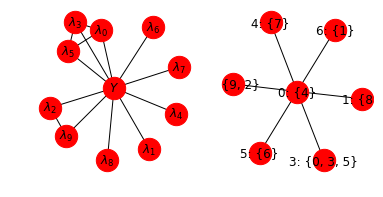

In [110]:
N = 10000 #not used
M = 10
K=2
N_CLUSTERS = M-1
EDGE_PROB = 1.0
HIGHER_ORDER_CLIQUES = False


deps_graph = ClusterDependencies(M, N_CLUSTERS, edge_prob=EDGE_PROB)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
deps_graph.draw()

data = DataGenerator(
    n=N,
    m=M,
    k=K,
    abstains=False,
    class_balance = [0.5, 0.5],
    deps_graph=deps_graph,
    param_ranges={
            "theta_acc_range": (0.1, 1),
            "theta_edge_range": (0.1, 1),
        },
    higher_order_cliques=HIGHER_ORDER_CLIQUES
)
plt.subplot(1,2,2)
data.jt.draw()

In [111]:
sigma_O = data.get_sigma_O()
E_O = np.array([data.P_marginal(v) for i, v in data.jt.iter_observed()])
class_balance = data.get_class_balance()

L, Y = data.generate_label_matrix(N)

## Train LabelModel with Independent LF Assumption
Note we use the class balance since these are observable/we assume are known

In [112]:
#Create junction tree with no dependencies between LFs
edges_ind = []
for i in range(M):
    edges_ind.append((i,M))

jt_ind = JunctionTree(
            M,
            K,
            abstains=False,
            edges=edges_ind,
            higher_order_cliques=HIGHER_ORDER_CLIQUES
        )

#Train LabelModel
lm = LabelModel(k=K)

lm.train(
    L_train=L,
    class_balance=class_balance,
    junction_tree=jt_ind,
    lr=1e-2,
    n_epochs=5000,
    print_every=500
)

mu = data.get_mu()
np.mean(np.abs(lm.mu - mu))

Estimating Z...
[E:0]	Train Loss: 83.53109741
[E:500]	Train Loss: 0.21893024
[E:1000]	Train Loss: 0.21893023
[E:1500]	Train Loss: 0.21893024
[E:2000]	Train Loss: 0.21893027
[E:2500]	Train Loss: 0.21893024
[E:3000]	Train Loss: 0.21893023
[E:3500]	Train Loss: 0.21893027
[E:4000]	Train Loss: 0.21893024
[E:4500]	Train Loss: 0.21893023
[E:4999]	Train Loss: 0.21893024
Finished Training


0.0018634291374019008

## Dependency Learning with RPCA

In [113]:
L_conflict

array([[-1.,  1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [ 1., -1.,  1., ...,  1., -1., -1.],
       [-1., -1.,  1., ...,  1., -1.,  1.],
       [-1., -1., -1., ...,  1., -1., -1.]])

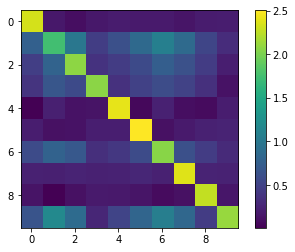

In [114]:
L_conflict = 2*(L-1.5)
Y_conflict = 2*(Y-1.5)

O = np.dot(L_conflict.T,L)/(N-1)
accuracies = np.array([np.mean(L_conflict[:,i] == Y_conflict) for i in range(M)])
mu_from_acc = 2*accuracies - 1
    
    
sig = O - np.outer(mu_from_acc,mu_from_acc)
sig_inv = np.linalg.pinv(sig)

plt.imshow(np.abs(sig_inv))
plt.colorbar()

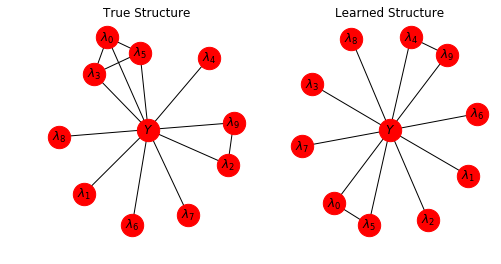

In [125]:
sigma_O_inv = np.linalg.inv(sigma_O)
dl = DependencyLearner(M,Oinv)
edges_est = dl.edges_from_rpca(thresh=0.2)
deps_graph_est = DependenciesGraph(M, edges_est)


plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title('True Structure')
deps_graph.draw()
plt.subplot(1,2,2)
plt.title('Learned Structure')
deps_graph_est.draw()

In [126]:
for i in range(M):
    edges_est.append((i,M))

jt_est = JunctionTree(
            M,
            K,
            abstains=False,
            edges=edges_est,
            higher_order_cliques=HIGHER_ORDER_CLIQUES
        )

lm_deps = LabelModel(k=K)
lm_deps.train(
    L_train=L,
    class_balance=class_balance,
    junction_tree=jt_est,
    lr=5e-2,
    n_epochs=5000,
    print_every=500,
    l2=1e-5
)

Estimating Z...
[E:0]	Train Loss: 183.23280334


Exception: Loss is NaN. Consider reducing learning rate.

In [ ]:
mu = data.get_mu()
print ("Error with independence assumption: ", np.mean(np.abs(mu - lm.mu)))
print ("Error with dependency learning    : ", np.mean(np.abs(mu - lm_deps.mu)))